In [1]:
import numpy as np
import matplotlib.pyplot as plt
import flopy
import mathieu_functions_OG as mf

In [2]:
#Parameter
alpha_l = 10
alpha_t = 1
beta = 1/(2*alpha_l)
C0 = 10
Ca = 8
gamma = 3.5
r = 1
d = np.sqrt((r*np.sqrt(alpha_l/alpha_t))**2-r**2)           #focal distance: c**2 = a**2 - b**2 --> c = +/-SQRT(a**2 - b**2)
q = (d**2*beta**2)/4
# 2q = (d**2*beta**2)/2 --> q = (see above)

n = 7             #Number of terms in mathieu series -1
M = 100           #Number of Control Points

#wrapper xy to eta psi
def uv(x, y):
    Y = np.sqrt(alpha_l/alpha_t)*y
    B = x**2+Y**2-d**2
    p = (-B+np.sqrt(B**2+4*d**2*x**2))/(2*d**2)
    q = (-B-np.sqrt(B**2+4*d**2*x**2))/(2*d**2)

    psi_0 = np.arcsin(np.sqrt(p))

    if Y >= 0 and x >= 0:
        psi = psi_0
    if Y < 0 and x >= 0:
        psi = np.pi-psi_0
    if Y <= 0 and x < 0:
        psi = np.pi+psi_0
    if Y > 0 and x < 0:
        psi = 2*np.pi-psi_0

    eta = 0.5*np.log(1-2*q+2*np.sqrt(q**2-q))
    return eta, psi

#polar coordinates
phi = np.linspace(0, 2*np.pi, M)
x1 = r*np.cos(phi)
y1 = r*np.sin(phi)

#elliptic coordinates
uv_vec = np.vectorize(uv)
psi1 = uv_vec(x1, y1)[1]
eta1 = uv_vec(x1, y1)[0]

#Mathieu Functions
m = mf.mathieu(q)

def Se(order, psi):                    #even angular first kind
    return m.ce(order, psi).real
def So(order, psi):                    #odd angular first kind
    return m.se(order, psi).real
def Ye(order, eta):                    #even radial second Kind
    return m.Ke(order, eta).real
def Yo(order, eta):                    #odd radial second Kind
    return m.Ko(order, eta).real

#Target Function
def F1(x1):
    return (C0*gamma+Ca)*np.exp(-beta*x1)

#System of Equations to calculate coefficients
lst = []                                                                        #empty array

for i in range(0, M):                                                            #filling array with all terms of MF for the source
    for j in range(0, 1):
        lst.append(Se(j, psi1[i])*Ye(j, eta1[i]))
    for j in range(1, n):
        lst.append(So(j, psi1[i])*Yo(j, eta1[i]))
        lst.append(Se(j, psi1[i])*Ye(j, eta1[i]))

F_M = []
s = 2*n-1
for k in range(0, len(lst), s):                                                   #appending each line (s elements) as arrays (in brackets) -> achieve right array structure (list of arrays)
    F_M.append(lst[k:k+s])

F = []

for u in range(0, M):                                                            #target function vector
    F.append(F1(x1[u])) #

Coeff = np.linalg.lstsq(F_M, F, rcond=None)                                       #calculated coefficients and residual
#print(Coeff[0])

#comprehensive solution
def c(x, y):
    if (x**2+y**2)<=r**2:
        return gamma*C0+Ca
    eta = uv(x, y)[0]
    psi = uv(x, y)[1]

    F = Coeff[0][0]*Se(0, psi)*Ye(0, eta)
    for w in range(1, n):
        F += Coeff[0][2*w-1]*So(w, psi)*Yo(w, eta) \
            + Coeff[0][2*w]*Se(w, psi)*Ye(w, eta)
    return ((F*np.exp(beta*x))).round(9)

In [3]:
#Domain

Lx = 200
ncol = int(Lx/1)
Ly = 51
nrow = int(Ly/1)

nlay=1

In [4]:
#calculate BC input for numerical model at domain extent: -150<x<450; -100<y<100
upper_lower_bc = []
for i in range(int(-(0.25*Lx)), int(0.75*Lx)):
    upper_lower_bc.append(c(i, 0.5*(Ly-1)))
left_bc = []
for i in range(int(-0.5*(Ly-1)), int(0.5*(Ly+1))):
    left_bc.append(c(-(0.25*Lx), i))
right_bc = []
for i in range(int(-0.5*(Ly-1)), int(0.5*(Ly+1))):
    right_bc.append(c(0.75*Lx, i))

In [5]:
#Parameter

prsity = 0.3
al = 10
ath = al*0.1
Gamma = 3.5
Cd = 10
Cd2 = 10
Ca = 8
h1 = 100
h2 = 1
hk = 1e-4

In [6]:
#Exe

exe_name_mf = 'mf2005.exe'
exe_name_mt = 'mt3dms.exe'

In [7]:
#Flow Calculation

mf = flopy.modflow.Modflow(modelname='T02_mf', exe_name=exe_name_mf)
dis = flopy.modflow.ModflowDis(mf, nlay=nlay, nrow=nrow, ncol=ncol, delr=Lx/ncol, delc=Ly/nrow, top=0, botm=-1, itmuni=1, perlen = 1e8)

ibound=np.ones((nlay, nrow, ncol), dtype=np.int32)
ibound[:,:,0] = -1
ibound[:,:,-1] = -1
strt=np.ones((nlay, nrow, ncol), dtype=np.float32)
strt[:,:,0] = h1
strt[:,:,-1] = h2

bas = flopy.modflow.ModflowBas(mf, ibound=ibound, strt=strt)
lpf = flopy.modflow.ModflowLpf(mf, hk=hk, laytyp=0)
gmg = flopy.modflow.ModflowGmg(mf)
lmt = flopy.modflow.ModflowLmt(mf)

mf.write_input()
mf.run_model(silent=True)

(True, [])

In [8]:
#Transport Calculation

mt = flopy.mt3d.Mt3dms(modelname='T02_mt', exe_name=exe_name_mt, modflowmodel=mf)

icbund = np.ones((nlay, nrow, ncol), dtype=np.int32)

icbund[:,:,0] = -1
icbund[:,:,-1] = -1
icbund[:,0,:] = -1
icbund[:,-1,:] = -1

icbund[:,int(0.5*nrow)-1,int(0.25*ncol)-1:int(0.25*ncol)] = -1
icbund[:,int(0.5*nrow),int(0.25*ncol)-1:int(0.25*ncol)] = -1

#icbund[:,int(0.5*nrow)-11,int(0.25*ncol)+10:int(0.25*ncol)+11] = -1
#icbund[:,int(0.5*nrow)-10,int(0.25*ncol)+10:int(0.25*ncol)+11] = -1

sconc = np.zeros((nlay, nrow, ncol), dtype=np.float32)

sconc[:,:,0] = left_bc 
sconc[:,:,-1] = right_bc 
sconc[:,0,:] = upper_lower_bc 
sconc[:,-1,:] = upper_lower_bc 

sconc[:,int(0.5*nrow)-1,int(0.25*ncol)-1:int(0.25*ncol)] = (Gamma*Cd+Ca)
sconc[:,int(0.5*nrow),int(0.25*ncol)-1:int(0.25*ncol)] = (Gamma*Cd+Ca)

#sconc[:,int(0.5*nrow)-11,int(0.25*ncol)+10:int(0.25*ncol)+11] = (Gamma*Cd)+(Ca)
#sconc[:,int(0.5*nrow)-10,int(0.25*ncol)+10:int(0.25*ncol)+11] = (Gamma*Cd)+(Ca)


btn = flopy.mt3d.Mt3dBtn(mt, icbund=icbund, prsity=prsity, sconc=sconc, ssflag=['sstate']) #, ssflag=['sstate']
adv = flopy.mt3d.Mt3dAdv(mt, mixelm=0)
dsp = flopy.mt3d.Mt3dDsp(mt, al=al, trpt=ath/al)
gcg = flopy.mt3d.Mt3dGcg(mt)
ssm = flopy.mt3d.Mt3dSsm(mt)

mt.write_input()
mt.run_model(silent=True)

(False, [])

In [9]:
ucnobj = flopy.utils.UcnFile('MT3D001.UCN')
conc = ucnobj.get_alldata()
mvt = mt.load_mas('MT3D001.MAS')

C:\Users\Anton\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:77: DeprecationWarning: backend2gui is deprecated since IPython 8.24, backends are managed in matplotlib and can be externally registered.
  warnings.warn(
C:\Users\Anton\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:77: DeprecationWarning: backend2gui is deprecated since IPython 8.24, backends are managed in matplotlib and can be externally registered.
  warnings.warn(
C:\Users\Anton\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:77: DeprecationWarning: backend2gui is deprecated since IPython 8.24, backends are managed in matplotlib and can be externally registered.
  warnings.warn(
C:\Users\Anton\anaconda3\Lib\site-packages\flopy\plot\map.py:241: UserWarning: The following kwargs were not used by contour: 'label'
  else ax.contour(xcentergrid, ycentergrid, plotarray, **kwargs)
C:\Users\Anton\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:77: DeprecationWarning: backend2gui is deprecated sin

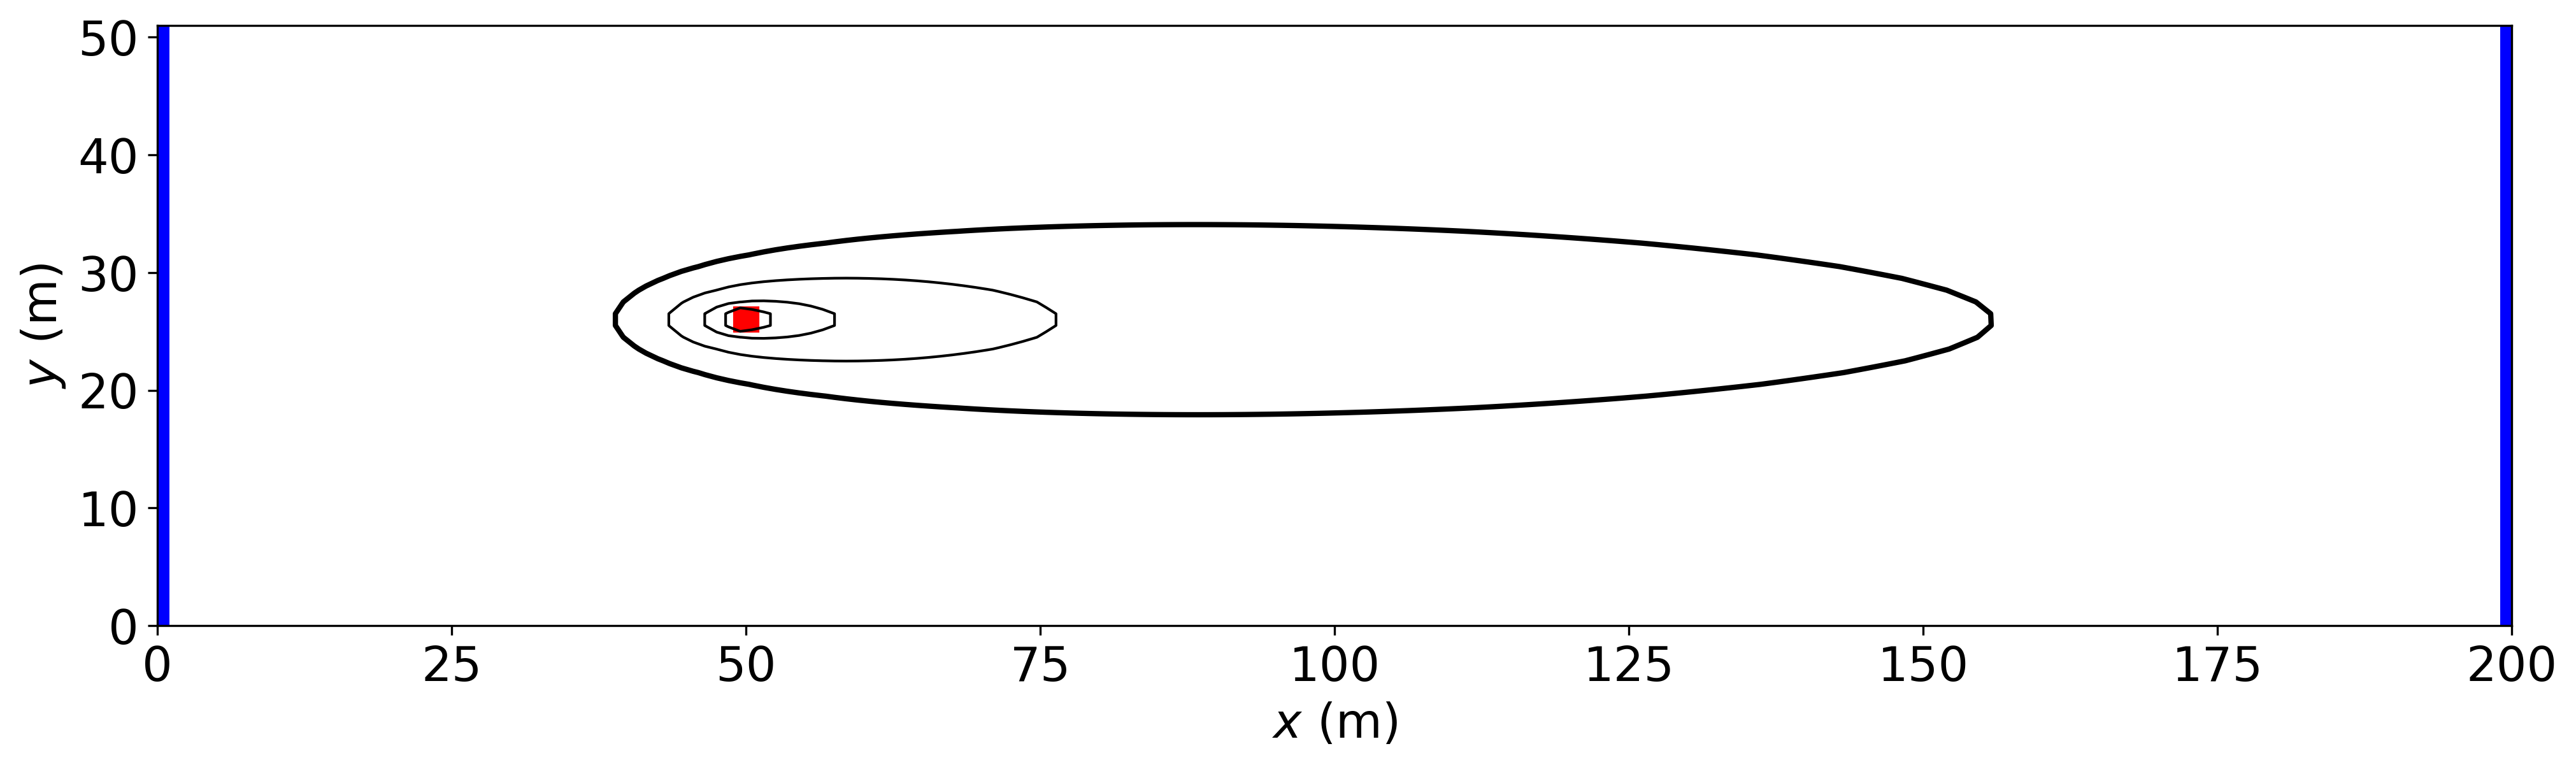

In [10]:
#Plot

C0=Ca
plt.figure(figsize=(16, 16*(Ly/Lx)), dpi=300)
plt.rcParams.update({'font.size': 18})
ax = plt.axes()
plt.axis('scaled')
mm = flopy.plot.map.PlotMapView(ax=ax, model=mf)
#mm.plot_grid(color='.5', alpha=0.2)
conc = conc[0, 0, :]
cs = mm.contour_array(conc, levels=np.linspace(15, (Gamma*Cd)+(Ca), 4), linewidths=1, colors='k')
cs_plume = mm.contour_array(conc, levels=[C0], linewidths=2, colors='k', label=r'$C_D = C_A = 0$')#np.linspace(C0, Gamma*Cd+C0, 5)
mm.plot_ibound()
plt.xlabel(r'$x$ (m)')
plt.ylabel(r'$y$ (m)')
Source = plt.Rectangle((0.25*Lx-1, 0.5*(Ly-1)), 2, 2, color = 'r')
plt.gca().add_patch(Source)

#plt.text(175,45, r'$\Delta x = 1 $m')
#plt.text(175,40, r'$\Delta y = 1 $m')
#rectangle = plt.Rectangle((174, 38), 20, 12, facecolor='lightgrey', edgecolor='black', linewidth=1)
#plt.gca().add_patch(rectangle)
#plt.clabel(cs_plume, inline = True, fmt=r'$C_D = C_A = 0$')
#plt.title('Contaminant Plume')
plt.savefig('modflow_01_2s.pdf', bbox_inches='tight')

In [11]:
#Plume length

p1 = cs_plume.collections[0].get_paths()[0]
coor_p1 = p1.vertices
np.max(coor_p1[:,0])-np.min(coor_p1[:,0])

C:\Users\Anton\AppData\Local\Temp\ipykernel_112552\1750840616.py:3: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  p1 = cs_plume.collections[0].get_paths()[0]


116.87542604385732